In [1]:
train_time = 1
param_num = 450340
local_data_num = 15
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 
comm_time = param_num * 4 / comm_bandwidth
fwdgrad_time_per_round = train_time*local_data_num + comm_time*local_data_num
fedsgd_time_per_round = train_time*8*local_data_num + comm_time*local_data_num*2
fedavg_time_per_round = train_time*8*local_data_num + comm_time*1*2
fwdgrad_time_per_round /= 60
fedsgd_time_per_round /= 60
fedavg_time_per_round /= 60
method_round_time = [fedavg_time_per_round,fedsgd_time_per_round,fwdgrad_time_per_round]
method_to_time = {"fedFwd":fwdgrad_time_per_round,"fedsgd":fedsgd_time_per_round,"fedavg":fedavg_time_per_round}
dataset = "agnews"

In [2]:
train_time = 1
param_num = 450340
local_data_num = 15
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 
comm_time = param_num * 4 / comm_bandwidth
fwdgrad_time_per_round = train_time*local_data_num + comm_time*local_data_num
fedsgd_time_per_round = train_time*8*local_data_num + comm_time*local_data_num*2
fedavg_time_per_round = train_time*8*local_data_num + comm_time*1*2
fwdgrad_time_per_round /= 60
fedsgd_time_per_round /= 60
fedavg_time_per_round /= 60
method_round_time = [fedavg_time_per_round,fedsgd_time_per_round,fwdgrad_time_per_round]
method_to_time = {"fedFwd":fwdgrad_time_per_round,"fedsgd":fedsgd_time_per_round,"fedavg":fedavg_time_per_round}
dataset = "agnews"

In [3]:
method_to_time

{'fedFwd': 0.5935821533203125,
 'fedsgd': 2.687164306640625,
 'fedavg': 2.0458109537760416}

In [4]:
def round_to_time(round,adhoc,eval_frequence):
    adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list

In [5]:
def round_to_time(round,adhoc,eval_frequence,method):
    # adhoc = list(map(int,adhoc.split(",")))
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "fedFwd":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*8*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "fedFwd":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*8*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list

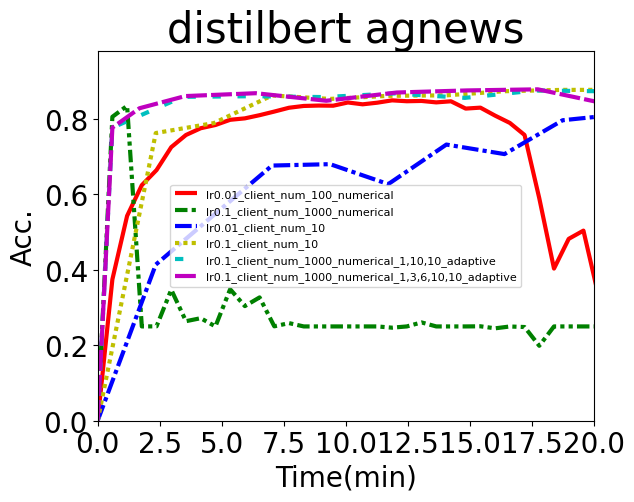

In [6]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np

eval_frequence = 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3
step = 0

method_to_time["fedFwd"] = (train_time*local_data_num + comm_time*local_data_num)/60
logdir = "/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/distilbert_agnews"
for i,file in enumerate(sorted(os.listdir(logdir))):
    if file.endswith(".log"):
        acc = [0]
        with open(logdir+"/"+file,"r") as f:
            log = f.readlines()
            for l in log:
                if "'acc':" in l:
                    acc.append(float(l[l.rfind("'acc':")+7:l.rfind(",")]))
                # if len(acc)>200:
                #     break
            method = file.split("_")[0]
            adhoc = None
            plt.plot(round_to_time(len(acc),adhoc,eval_frequence,method), acc, linestyle=linestyle[i-step], color=colors[i-step],label=file.replace(".log","").replace("fedFwd_distilbert_agnews_","").replace("fedsgd_distilbert_agnews_",""),linewidth=lw)
    elif file.endswith(".bak"):
        step += 1
# method_to_time["fedFwd"] = (train_time*local_data_num*7 + comm_time*local_data_num)/60

for j,file in enumerate(sorted(os.listdir(os.getcwd()))):
    if file.endswith(".log"):
        acc = [0]
        with open(file,"r") as f:
            log = f.readlines()
            for l in log:
                if "'acc':" in l:
                    acc.append(float(l[l.rfind("'acc':")+7:l.rfind(",")]))
                # if len(acc)>200:
                #     break
            method = file.split("_")[0]
            adhoc = file.split("_")[-1].split(".")[0]
            plt.plot(round_to_time(len(acc),adhoc,eval_frequence,method), acc, linestyle=linestyle[i+j-step], color=colors[i+j-step],label=file.replace(".log","").replace("fedFwd_distilbert_agnews_","").replace("fedSgd_distilbert_agnews_","")+"_adaptive",linewidth=lw)
    elif file.endswith(".bak"):
        step += 1
plt.xlabel("Time(min)",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,20)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"distilbert agnews",fontsize=30)
plt.show()

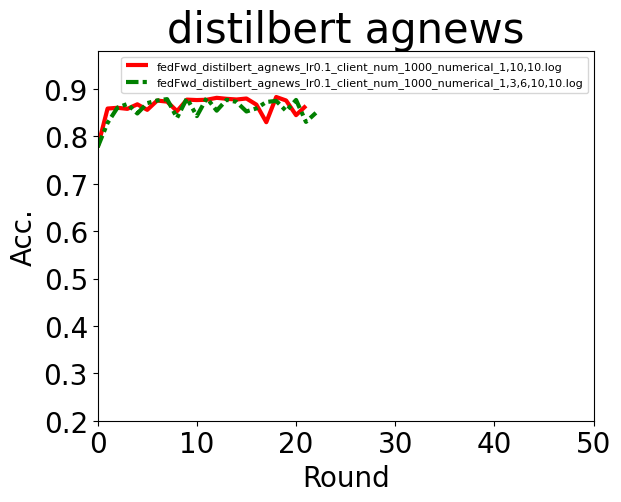

In [7]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np

eval_frequence = 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

for i,file in enumerate(sorted(os.listdir(os.getcwd()))):
    if file.endswith(".log"):
        acc = []
        with open(file,"r") as f:
            log = f.readlines()
            for l in log:
                if "'acc':" in l:
                    acc.append(float(l[l.rfind("'acc':")+7:l.rfind(",")]))
                # if len(acc)>200:
                #     break
            method = file.split("_")[0]
            plt.plot([t*eval_frequence for t in range(len(acc))], acc, linestyle=linestyle[i], color=colors[i],label=file,linewidth=lw)

plt.xlabel("Round",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,50)
plt.yticks(size = 20)
plt.ylim(0.2,0.98)
plt.legend(fontsize=8)
plt.title(f"distilbert agnews",fontsize=30)
plt.show()